In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix, r2_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression, f_classif
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
import warnings
warnings.filterwarnings('ignore')

# The data

In [4]:
# Load the data
df = pd.read_parquet('../data/climbs_data.parquet')

In [5]:
# Display basic information about the dataset
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35878 entries, 0 to 35877
Columns: 482 entries, uuid to led_476
dtypes: float64(1), int64(2), object(479)
memory usage: 131.9+ MB
None
              angle  difficulty_average  ascensionist_count
count  35878.000000        35878.000000        35878.000000
mean      36.769051           18.869318            9.355176
std       13.234911            4.063691           45.278211
min        0.000000           10.000000            1.000000
25%       30.000000           16.000000            1.000000
50%       40.000000           19.000000            2.000000
75%       45.000000           22.000000            4.000000
max       70.000000           33.000000         1547.000000


In [6]:
# Display first and last few rows of data:
print("Head:")
print(df.head(5))

print("Tail:")
print(df.tail(5))

Head:
                                   uuid  angle  difficulty_average  \
0  f01419e1-2672-4593-96ca-62e3655abc46      0             14.8857   
1  f01419e1-2672-4593-96ca-62e3655abc46      5             12.0000   
2  f01419e1-2672-4593-96ca-62e3655abc46     10             15.8571   
3  f01419e1-2672-4593-96ca-62e3655abc46     15             15.9526   
4  f01419e1-2672-4593-96ca-62e3655abc46     20             16.1127   

  boulder_grade  ascensionist_count     led_0     led_1     led_2     led_3  \
0            V3                  35  NOT_USED  NOT_USED  NOT_USED  NOT_USED   
1            V1                   2  NOT_USED  NOT_USED  NOT_USED  NOT_USED   
2            V3                 133  NOT_USED  NOT_USED  NOT_USED  NOT_USED   
3            V3                 190  NOT_USED  NOT_USED  NOT_USED  NOT_USED   
4            V3                 346  NOT_USED  NOT_USED  NOT_USED  NOT_USED   

      led_4  ...   led_467   led_468   led_469   led_470   led_471   led_472  \
0  NOT_USED  ...  

In [7]:
# Number of rows and columns before preprocessing
print(df.dtypes)

uuid                   object
angle                   int64
difficulty_average    float64
boulder_grade          object
ascensionist_count      int64
                       ...   
led_472                object
led_473                object
led_474                object
led_475                object
led_476                object
Length: 482, dtype: object


# Data Preprocessing

In [8]:
# Remove unnecessary columns
columns_to_drop = ['uuid']
df = df.drop(columns=columns_to_drop)

In [9]:
# Filter out records with fewer than 3 ascensionists
# If only one or 2 climbers have asecent it and rated it, the righting might not be too accurate
# hence forcing it to at least have 3 climbers ascent it to consider the grade valid
df = df[df['ascensionist_count'] >= 3]

In [10]:
# Convert boulder_grade to numeric (assuming V0 = 0, V1 = 1, etc.)
df['grade_numeric'] = df['boulder_grade'].str.extract('(\d+)').astype(float)

# Modeling

In [11]:
# Select features (hold positions and angle)
features = ['angle'] + [f'led_{i}' for i in range(1, 477)]
X = df[features]
y_reg = df['difficulty_average'] # using difficulty average for regression models
y_class = df['grade_numeric'] # using grade numeric for classifier

In [12]:
# Encode categorical variables (hold types)
X = pd.get_dummies(X, columns=[f'led_{i}' for i in range(1, 477)])

In [13]:
# Display information about the preprocessed dataset
print("\nPreprocessed dataset:")
print(X.info())
print(X.describe())


Preprocessed dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 14320 entries, 0 to 23160
Columns: 1833 entries, angle to led_476_NOT_USED
dtypes: bool(1832), int64(1)
memory usage: 25.2 MB
None
              angle
count  14320.000000
mean      37.500698
std       13.249922
min        0.000000
25%       30.000000
50%       40.000000
75%       45.000000
max       70.000000


In [14]:
X.head(5)

,angle,led_1_FEET-ONLY,led_1_MIDDLE,led_1_NOT_USED,led_1_START,led_2_FEET-ONLY,led_2_NOT_USED,led_3_FEET-ONLY,led_3_NOT_USED,led_4_FEET-ONLY,...,led_474_FINISH,led_474_MIDDLE,led_474_NOT_USED,led_474_START,led_475_FINISH,led_475_MIDDLE,led_475_NOT_USED,led_476_FEET-ONLY,led_476_FINISH,led_476_NOT_USED
0,0,False,False,True,False,False,True,False,True,False,...,False,False,True,False,False,False,True,False,False,True
2,10,False,False,True,False,False,True,False,True,False,...,False,False,True,False,False,False,True,False,False,True
3,15,False,False,True,False,False,True,False,True,False,...,False,False,True,False,False,False,True,False,False,True
4,20,False,False,True,False,False,True,False,True,False,...,False,False,True,False,False,False,True,False,False,True
5,25,False,False,True,False,False,True,False,True,False,...,False,False,True,False,False,False,True,False,False,True


In [15]:
# Split the data
X_train, X_test, y_reg_train, y_reg_test, y_class_train, y_class_test = train_test_split(
    X, y_reg, y_class, test_size=0.2, random_state=42)

In [16]:
# Create feature preprocessor
numeric_features = ['angle']
categorical_features = [col for col in X.columns if col.startswith('led_')]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', 'passthrough', categorical_features)
    ])

## Regression Models

## 1. Ridge

In [17]:
# Ridge Regression
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_regression)),
    ('regressor', Ridge())
])

In [18]:
ridge_param_grid = {
    'feature_selection__k': [100, 200, 300],
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
}

In [19]:
# Ridge Regression
print("\nTraining Ridge Regression...")
ridge_grid = GridSearchCV(ridge_pipeline, ridge_param_grid, cv=5, 
                         scoring='neg_mean_squared_error', n_jobs=-1)
ridge_grid.fit(X_train, y_reg_train)
ridge_pred = ridge_grid.predict(X_test)
ridge_mse = mean_squared_error(y_reg_test, ridge_pred)
ridge_r2 = r2_score(y_reg_test, ridge_pred)

print("Ridge Regression Results:")
print(f"Best parameters: {ridge_grid.best_params_}")
print(f"MSE: {ridge_mse}")
print(f"R-squared: {ridge_r2}")



Training Ridge Regression...
Ridge Regression Results:
Best parameters: {'feature_selection__k': 300, 'regressor__alpha': 1.0}
MSE: 6.515832691247712
R-squared: 0.6207083329040406


Text(0.5, 1.0, 'Ridge Regression: Predicted vs Actual')

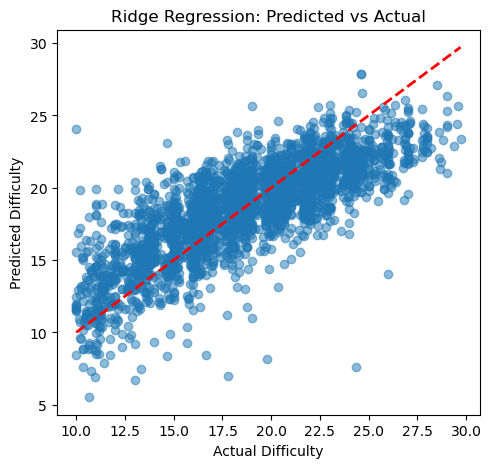

In [20]:
# Visualizations

# Regression predictions vs actual
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_reg_test, ridge_pred, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()], 
         [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('Actual Difficulty')
plt.ylabel('Predicted Difficulty')
plt.title('Ridge Regression: Predicted vs Actual')

## 2. Random Forest Regression

In [21]:
# Random Forest Regression
rf_reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])


In [22]:
rf_reg_param_grid = {
    'regressor__n_estimators': [100],
    'regressor__max_depth': [None, 20],
    'regressor__min_samples_split': [2]
}

In [23]:
# Random Forest Regression
print("\nTraining Random Forest Regression...")
rf_reg_grid = GridSearchCV(rf_reg_pipeline, rf_reg_param_grid, cv=3, 
                          scoring='neg_mean_squared_error', n_jobs=-1)
rf_reg_grid.fit(X_train, y_reg_train)
rf_reg_pred = rf_reg_grid.predict(X_test)
rf_reg_mse = mean_squared_error(y_reg_test, rf_reg_pred)
rf_reg_r2 = r2_score(y_reg_test, rf_reg_pred)

print("Random Forest Regression Results:")
print(f"Best parameters: {rf_reg_grid.best_params_}")
print(f"MSE: {rf_reg_mse}")
print(f"R-squared: {rf_reg_r2}")


Training Random Forest Regression...
Random Forest Regression Results:
Best parameters: {'regressor__max_depth': None, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
MSE: 4.56429448272639
R-squared: 0.7343088833763968


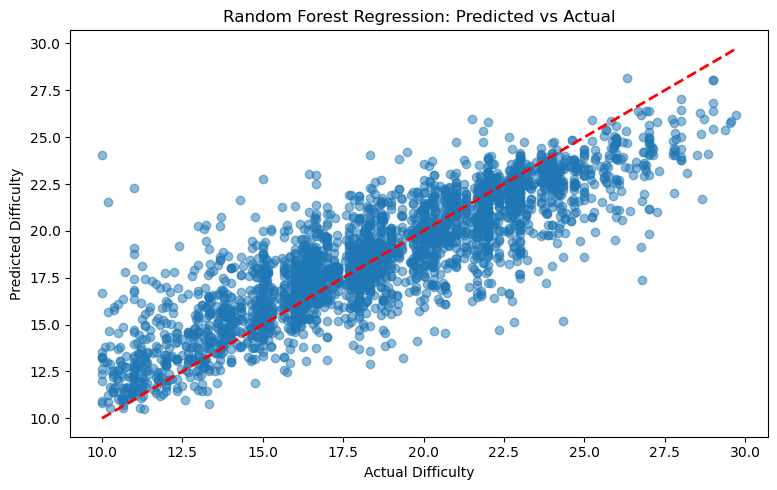

In [24]:
plt.figure(figsize=(15, 5))

# Random Forest Regression
plt.subplot(1, 2, 1)
plt.scatter(y_reg_test, rf_reg_pred, alpha=0.5)
plt.plot([y_reg_test.min(), y_reg_test.max()], 
         [y_reg_test.min(), y_reg_test.max()], 'r--', lw=2)
plt.xlabel('Actual Difficulty')
plt.ylabel('Predicted Difficulty')
plt.title('Random Forest Regression: Predicted vs Actual')

plt.tight_layout()
plt.show()

# Classification Models

## 1. Logistic Regression

In [25]:
# Logistic Regression Pipeline
log_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        multi_class='ovr',  # One-vs-rest is typically faster than 'multinomial'
        random_state=42,
        tol=1e-3,          # Increase tolerance (default is 1e-4) for faster convergence
        max_iter=1000,
        solver='saga',
        n_jobs=-1,         # Parallelize when possible
        warm_start=True,   # Use previous solution to start next fit
        dual=False         # Dual=False is faster when n_samples > n_features
    ))
])


In [26]:
log_param_grid = {
    'classifier__C': [1.0],    # Single value for faster grid search
    'classifier__max_iter': [1000]
}

In [27]:
# GridSearchCV with minimal cross-validation
log_grid = GridSearchCV(
    log_pipeline, 
    log_param_grid, 
    cv=3,                # Minimum recommended number of folds
    scoring='accuracy',
    n_jobs=-1,          # Use all CPU cores
    error_score='raise', # Raise errors immediately
    verbose=1,          # Add progress messages
    return_train_score=False  # Don't compute training scores (saves time)
)

In [28]:
# Logistic Regression
print("\nTraining Logistic Regression...")
log_grid.fit(X_train, y_class_train)
log_pred = log_grid.predict(X_test)
log_accuracy = accuracy_score(y_class_test, log_pred)

print("Logistic Regression Results:")
print(f"Best parameters: {log_grid.best_params_}")
print(f"Accuracy: {log_accuracy}")
print("\nClassification Report:")
print(classification_report(y_class_test, log_pred))



Training Logistic Regression...
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Logistic Regression Results:
Best parameters: {'classifier__C': 1.0, 'classifier__max_iter': 1000}
Accuracy: 0.3299581005586592

Classification Report:
              precision    recall  f1-score   support

         0.0       0.52      0.52      0.52       146
         1.0       0.37      0.22      0.28       202
         2.0       0.28      0.12      0.16       137
         3.0       0.39      0.57      0.46       474
         4.0       0.31      0.35      0.33       470
         5.0       0.29      0.30      0.30       430
         6.0       0.16      0.10      0.13       162
         7.0       0.21      0.14      0.17       272
         8.0       0.35      0.48      0.40       366
         9.0       0.09      0.04      0.06        70
        10.0       0.26      0.17      0.20        59
        11.0       0.12      0.02      0.04        41
        12.0       0.00      0.00      0.00        21

Text(0.5, 1.0, 'Logistic Regression: Predicted vs Actual')

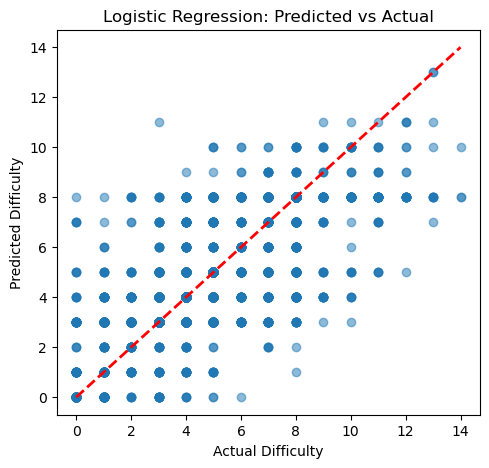

In [30]:
# Visualizations

# Logistic Regression predictions vs actual
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_class_test, log_pred, alpha=0.5)
plt.plot([y_class_test.min(), y_class_test.max()], 
         [y_class_test.min(), y_class_test.max()], 'r--', lw=2)
plt.xlabel('Actual Difficulty')
plt.ylabel('Predicted Difficulty')
plt.title('Logistic Regression: Predicted vs Actual')

## 2. K-Nearest Neighbors Classification

In [31]:
# KNN Pipeline
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_classif)),
    ('classifier', KNeighborsClassifier(n_jobs=-1))
])

In [32]:
knn_param_grid = {
    'feature_selection__k': [400, 800, 1000],
    'classifier__n_neighbors': [6, 7, 8, 9, 10],
    'classifier__weights': ['uniform', 'distance']
}

In [33]:
# Train KNN
print("\nTraining K-Nearest Neighbors...")
knn_grid = GridSearchCV(knn_pipeline, knn_param_grid, cv=3, 
                       scoring='accuracy', n_jobs=-1)
knn_grid.fit(X_train, y_class_train)
knn_pred = knn_grid.predict(X_test)
knn_accuracy = accuracy_score(y_class_test, knn_pred)

print("KNN Results:")
print(f"Best parameters: {knn_grid.best_params_}")
print(f"Accuracy: {knn_accuracy}")
print("\nClassification Report:")
print(classification_report(y_class_test, knn_pred))


Training K-Nearest Neighbors...
KNN Results:
Best parameters: {'classifier__n_neighbors': 9, 'classifier__weights': 'distance', 'feature_selection__k': 1000}
Accuracy: 0.41166201117318435

Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.56      0.58       146
         1.0       0.51      0.38      0.44       202
         2.0       0.37      0.23      0.29       137
         3.0       0.48      0.54      0.51       474
         4.0       0.43      0.37      0.40       470
         5.0       0.44      0.43      0.43       430
         6.0       0.29      0.30      0.29       162
         7.0       0.36      0.24      0.29       272
         8.0       0.35      0.62      0.44       366
         9.0       0.18      0.16      0.17        70
        10.0       0.32      0.25      0.28        59
        11.0       0.33      0.12      0.18        41
        12.0       0.29      0.10      0.14        21
        13.0       0.75      0

Text(0.5, 1.0, 'K-Nearest Neighbor: Predicted vs Actual')

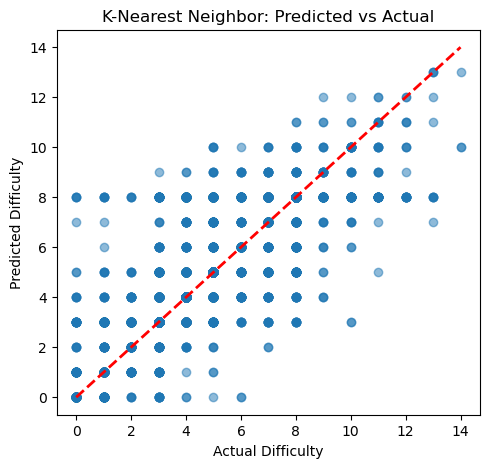

In [35]:
# Visualizations

# KNN Classifier predictions vs actual
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_class_test, knn_pred, alpha=0.5)
plt.plot([y_class_test.min(), y_class_test.max()], 
         [y_class_test.min(), y_class_test.max()], 'r--', lw=2)
plt.xlabel('Actual Difficulty')
plt.ylabel('Predicted Difficulty')
plt.title('K-Nearest Neighbor: Predicted vs Actual')

## 3. SVM

In [36]:
# SVM Pipeline
svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', SelectKBest(f_classif)),
    ('classifier', SVC(random_state=42))
])

In [39]:
svm_param_grid = {
    'feature_selection__k': [800], # removed 200 and 400 so it runs faster
    'classifier__C': [10.0], # removed 0.1 and 1.0 so it runs faster
    'classifier__kernel': ['rbf'],
    'classifier__gamma': ['scale']
}

In [40]:
# Train SVM
print("\nTraining Support Vector Machine...")
svm_grid = GridSearchCV(svm_pipeline, svm_param_grid, cv=3, 
                       scoring='accuracy', n_jobs=-1)
svm_grid.fit(X_train, y_class_train)
svm_pred = svm_grid.predict(X_test)
svm_accuracy = accuracy_score(y_class_test, svm_pred)

print("SVM Results:")
print(f"Best parameters: {svm_grid.best_params_}")
print(f"Accuracy: {svm_accuracy}")
print("\nClassification Report:")
print(classification_report(y_class_test, svm_pred))


Training Support Vector Machine...
SVM Results:
Best parameters: {'classifier__C': 10.0, 'classifier__gamma': 'scale', 'classifier__kernel': 'rbf', 'feature_selection__k': 800}
Accuracy: 0.3648743016759777

Classification Report:
              precision    recall  f1-score   support

         0.0       0.55      0.53      0.54       146
         1.0       0.47      0.28      0.35       202
         2.0       0.23      0.04      0.07       137
         3.0       0.42      0.61      0.50       474
         4.0       0.35      0.41      0.37       470
         5.0       0.31      0.35      0.33       430
         6.0       0.23      0.06      0.10       162
         7.0       0.20      0.09      0.12       272
         8.0       0.35      0.63      0.45       366
         9.0       0.00      0.00      0.00        70
        10.0       0.22      0.03      0.06        59
        11.0       0.33      0.02      0.05        41
        12.0       0.00      0.00      0.00        21
        13.0

Text(0.5, 1.0, 'SVM: Predicted vs Actual')

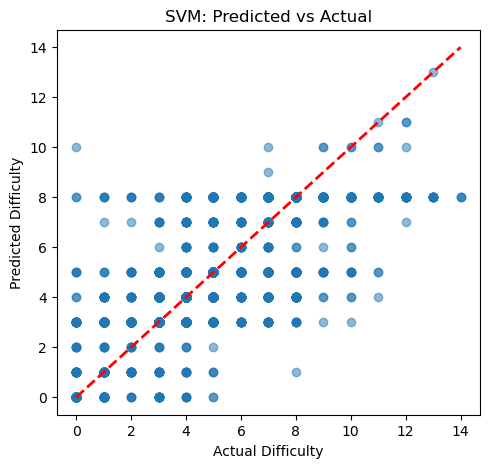

In [41]:
# Visualizations

# SVM predictions vs actual
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(y_class_test, svm_pred, alpha=0.5)
plt.plot([y_class_test.min(), y_class_test.max()], 
         [y_class_test.min(), y_class_test.max()], 'r--', lw=2)
plt.xlabel('Actual Difficulty')
plt.ylabel('Predicted Difficulty')
plt.title('SVM: Predicted vs Actual')

# Accuracy Metrics

In [42]:
def plot_accuracy_comparison(accuracies_dict):
    fig, ax = plt.subplots(figsize=(14, 6))
    
    bar_width = 0.15
    index = np.arange(3)  # Three accuracy metrics
    
    # Assign a unique color to each model
    colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, len(accuracies_dict)))
    color_dict = dict(zip(accuracies_dict.keys(), colors))
    
    # Prepare data for sorting
    sorted_data = [[] for _ in range(3)]
    for model_name, accuracies in accuracies_dict.items():
        for i, acc in enumerate(accuracies):
            sorted_data[i].append((model_name, acc))
    
    # Sort each accuracy range
    for i in range(3):
        sorted_data[i] = sorted(sorted_data[i], key=lambda x: x[1])
    
    # Plot bars
    for i in range(3):
        for j, (model_name, acc) in enumerate(sorted_data[i]):
            bar = ax.bar(index[i] + j*bar_width, acc, bar_width, 
                   color=color_dict[model_name], 
                   label=model_name if i == 0 else "")
            
            # Add accuracy number on top of each bar
            ax.text(index[i] + j*bar_width, acc, f'{acc:.2f}', 
                    ha='center', va='bottom', rotation=90, fontsize=8)
    
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Accuracy Comparison Across Models')
    ax.set_xticks(index + bar_width * (len(accuracies_dict) - 1) / 2)
    ax.set_xticklabels(['Exact', 'Within ±1.0', 'Within ±2.0'])
    
    # Adjust legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

In [43]:
import json

def load_grades(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

In [44]:
def map_to_v_grade(difficulty, grades):
    difficulty = int(round(difficulty))
    for grade in grades:
        if grade['difficulty'] == difficulty:
            v_grade = grade['boulder_name'].split('/')[1]
            return int(v_grade[1:])  # Extract the number after 'V'
    return -1  # Return -1 if no matching difficulty is found

In [45]:
def calculate_accuracy_metrics(y_true, y_pred, model_name, regression=True, grades=None):
    print(f"\nAccuracy Metrics for {model_name}:")
    
    if regression:
        # Map regression predictions to V-grade numbers
        y_pred_v = np.array([map_to_v_grade(pred, grades) for pred in y_pred])
        y_true_v = np.array([map_to_v_grade(true, grades) for true in y_true])
    else:
        # For classification, assume y_true and y_pred are already V-grade numbers
        y_pred_v = np.round(y_pred).astype(int)
        y_true_v = np.round(y_true).astype(int)
    
    # Calculate accuracies
    exact_match = np.mean(y_pred_v == y_true_v) * 100
    within_one = np.mean(abs(y_pred_v - y_true_v) <= 1) * 100
    within_two = np.mean(abs(y_pred_v - y_true_v) <= 2) * 100
    
    print(f"Exact V-grade match: {exact_match:.2f}%")
    print(f"Predictions within ±1 V-grade: {within_one:.2f}%")
    print(f"Predictions within ±2 V-grades: {within_two:.2f}%")
    
    return [exact_match, within_one, within_two]

In [49]:
# Load grades
grades = load_grades('../scripts/grades.json')


In [50]:
# Calculate metrics for all models
print("Calculating accuracy metrics for all models...")

accuracies = {}

# Regression Models
accuracies["Ridge Regression"] = calculate_accuracy_metrics(y_reg_test, ridge_pred, "Ridge Regression", regression=True, grades=grades)
accuracies["Random Forest Regression"] = calculate_accuracy_metrics(y_reg_test, rf_reg_pred, "Random Forest Regression", regression=True, grades=grades)

# Classification Models
accuracies["Logistic Regression"] = calculate_accuracy_metrics(y_class_test, log_pred, "Logistic Regression", regression=False)
accuracies["K-Nearest Neighbors"] = calculate_accuracy_metrics(y_class_test, knn_pred, "K-Nearest Neighbors Classification", regression=False)
accuracies["SVM Classification"] = calculate_accuracy_metrics(y_class_test, svm_pred, "SVM Classification", regression=False)

Calculating accuracy metrics for all models...

Accuracy Metrics for Ridge Regression:
Exact V-grade match: 28.14%
Predictions within ±1 V-grade: 67.28%
Predictions within ±2 V-grades: 87.36%

Accuracy Metrics for Random Forest Regression:
Exact V-grade match: 37.08%
Predictions within ±1 V-grade: 76.40%
Predictions within ±2 V-grades: 91.90%

Accuracy Metrics for Logistic Regression:
Exact V-grade match: 33.00%
Predictions within ±1 V-grade: 63.13%
Predictions within ±2 V-grades: 80.80%

Accuracy Metrics for K-Nearest Neighbors Classification:
Exact V-grade match: 41.17%
Predictions within ±1 V-grade: 70.22%
Predictions within ±2 V-grades: 84.36%

Accuracy Metrics for SVM Classification:
Exact V-grade match: 36.49%
Predictions within ±1 V-grade: 67.63%
Predictions within ±2 V-grades: 82.37%


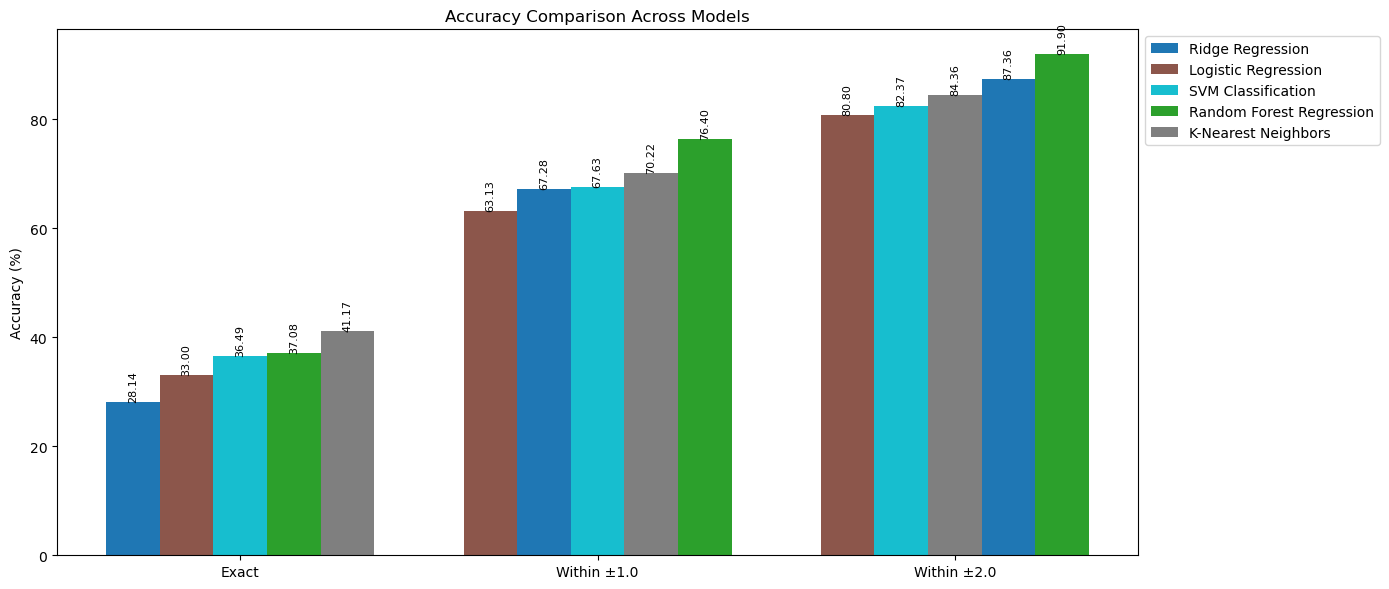

In [51]:
# Plot the comparison
plot_accuracy_comparison(accuracies)